In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

In [12]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

In [9]:
def build_model(optimizer='adam'):
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [10]:
optimizers = ['adam', 'sgd']
batch_sizes = [64, 128]
best_acc = 0
best_params = {}
for opt in optimizers:
    for bs in batch_sizes:
        model = build_model(optimizer=opt)
        history = model.fit(x_train, y_train_cat, epochs=3, batch_size=bs, verbose=0, validation_data=(x_test, y_test_cat))
        acc = history.history['val_accuracy'][-1]
        print(f"Optimizer: {opt}, Batch size: {bs}, Val Acc: {acc:.4f}")
        if acc > best_acc:
            best_acc = acc
            best_params = {'optimizer': opt, 'batch_size': bs}

print("Best params:", best_params)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Optimizer: adam, Batch size: 64, Val Acc: 0.9708
Optimizer: adam, Batch size: 128, Val Acc: 0.9669
Optimizer: sgd, Batch size: 64, Val Acc: 0.9107
Optimizer: sgd, Batch size: 128, Val Acc: 0.8973
Best params: {'optimizer': 'adam', 'batch_size': 64}


In [11]:
final_model = build_model(optimizer=best_params['optimizer'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)
history = final_model.fit(
    x_train, y_train_cat,
    epochs=10,
    batch_size=best_params['batch_size'],
    validation_data=(x_test, y_test_cat),
    callbacks=[reduce_lr]
)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8599 - loss: 0.5150 - val_accuracy: 0.9530 - val_loss: 0.1630 - learning_rate: 0.0010
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9555 - loss: 0.1525 - val_accuracy: 0.9653 - val_loss: 0.1150 - learning_rate: 0.0010
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9710 - loss: 0.0983 - val_accuracy: 0.9724 - val_loss: 0.0921 - learning_rate: 0.0010
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9795 - loss: 0.0715 - val_accuracy: 0.9728 - val_loss: 0.0879 - learning_rate: 0.0010
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9831 - loss: 0.0565 - val_accuracy: 0.9740 - val_loss: 0.0817 - learning_rate: 0.0010
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9869 - loss: 0.0464 - val_accuracy: 0.9739 - val_loss: 0.0880 - learning_rate: 0.0010
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9893 - loss: 0.0350 - 

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


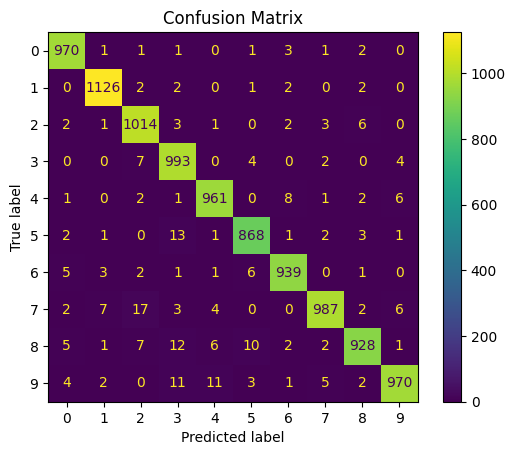

In [13]:
y_pred = np.argmax(final_model.predict(x_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

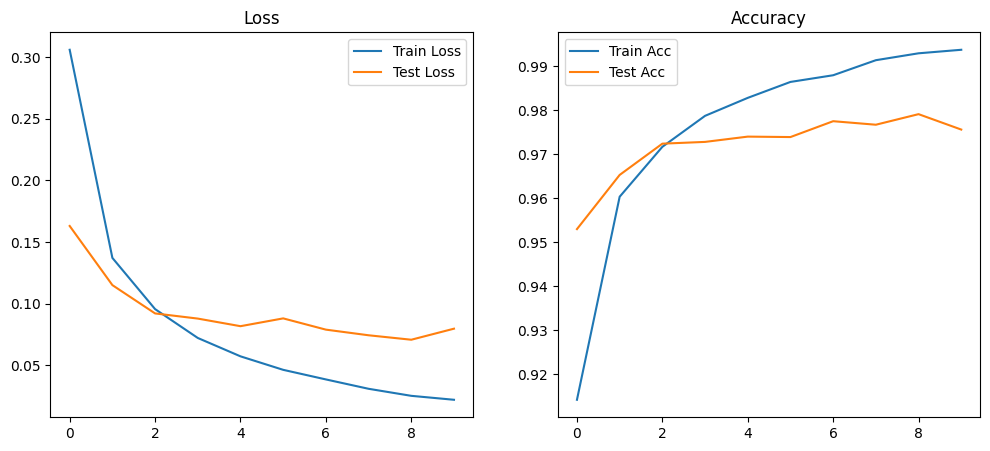

In [14]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend()
plt.title('Loss')
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Test Acc')
plt.legend()
plt.title('Accuracy')
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


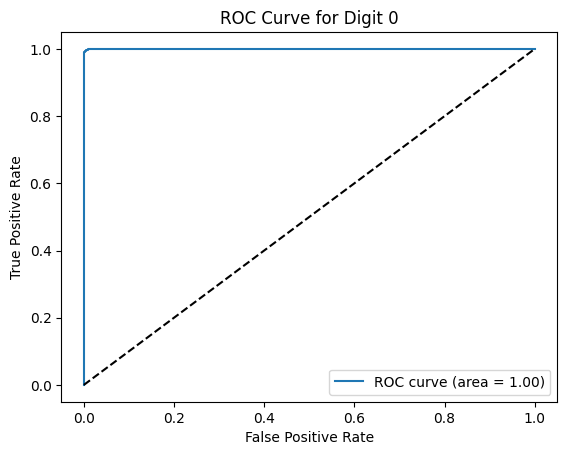

In [15]:
y_score = final_model.predict(x_test)
fpr, tpr, _ = roc_curve(y_test_cat[:, 0], y_score[:, 0])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Digit 0')
plt.legend()
plt.show()